# Preparación del entorno y carga de datos

In [3]:
!sudo apt-get install unzip
!sudo apt-get install sox
!pip install opensmile

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


^C


In [33]:
import datetime
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import opensmile
import os
import pandas as pd
import pickle
import seaborn as sns
import sox 
import sweetviz as sv
import time
import tqdm
from matplotlib import pyplot
from numpy import mean, std
from pathlib import Path
from urllib.parse import urlparse

In [2]:
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import randint as sp_randint

from sklearn.calibration import calibration_curve
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
)
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    roc_curve,
    auc,
    make_scorer,
    accuracy_score,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score, LeaveOneGroupOut

## Instancias a dataset a predecir

In [6]:
!unzip ./Propios/audios_propios.zip -d ./Propios/ravdess_propios

'unzip' is not recognized as an internal or external command,
operable program or batch file.


**Recorrer estructuras de archivos y extraer metadata**

In [7]:
ravdess = []
for file_path in glob.glob("./Propios/ravdess_propios/*.wav"):
    filename = Path(file_path).stem
    filename_parts = filename.split("-")
    metadata = {
        "file_path": file_path,
        "modality": filename_parts[0],
        "vocal_channel": filename_parts[1],
        "emotion": filename_parts[2],
        "emotional_intensity": filename_parts[3],
        "statement": filename_parts[4],
        "repetition": filename_parts[5],
        "actor": filename_parts[6],
    }
    ravdess.append(metadata)

df_ravdess_propios = pd.DataFrame(ravdess)

In [8]:
start = time.time()

feat_aux = []
for j in os.listdir("./Propios/ravdess_propios"):
    filename = "./Propios/ravdess_propios/" + j
    print("./Propios/ravdess_propios/" + j)

    ch = sox.file_info.channels(filename)
    print(f"channel: {ch}")
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
        num_channels=ch,
    )

    feats = smile.process_file(filename)
    feats = feats.reset_index()
    feat_aux.append(feats)

end = time.time()
print(f"Tiempo: { round(end - start, 2) } segundos")

./Propios/ravdess_propios/03-01-01-01-01-01-05.wav


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
df_ravdess_propios.shape

**Calculamos los atributos de alto nivel (Functionals)**

In [ ]:
df_feats = pd.concat(feat_aux)
df_feats = df_feats.rename(columns={"file": "file_path"})

In [ ]:
df_feats.head()

In [ ]:
df_propios = pd.merge(df_ravdess_propios, df_feats, on="file_path", how="left")

In [ ]:
num_columns = [col for col in df_propios.columns if df_propios[col].dtype != "object"]
num_columns

In [ ]:
df_propios.shape

In [3]:
drop_columns = [
    "file_path",
    "start",
    "end",
    #     "Unnamed: 0",
    #     'Unnamed: 0.1',
    "modality",  # 03 = audio-only
    "vocal_channel",  # (01 = speech, 02 = song).
    #     "emotion",
    "emotional_intensity",  # (01 = normal, 02 = strong)
    "statement",  # (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    "repetition",  # (01 = 1st repetition, 02 = 2nd repetition).
    "actor",  # (01 to 24. Odd numbered actors are male, even numbered actors are female).
]

In [4]:
df_propios = df_propios.drop(drop_columns, axis=1)
# df_propios.to_csv('05.01.df_propios.csv')

NameError: name 'df_propios' is not defined

In [5]:
df_propios = pd.read_csv("05.01.df_propios.csv")

<BarContainer object of 7 artists>

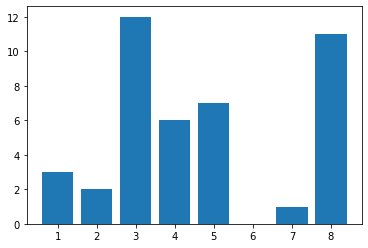

In [6]:
plt.bar(
    df_propios.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_propios.groupby(["emotion"]).loudness_sma3_amean.count(),
)

In [7]:
x_propios = df_propios.loc[:, df_propios.columns != "emotion"]

In [8]:
y_propios = np.int64(df_propios["emotion"])

In [9]:
drop_columns = [
    "file_path",
    "start",
    "end",
    "Unnamed: 0",
    "Unnamed: 0.1",
    "modality",  # 03 = audio-only
    "vocal_channel",  # (01 = speech, 02 = song).
    #     "emotion",
    "emotional_intensity",  # (01 = normal, 02 = strong)
    "statement",  # (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    "repetition",  # (01 = 1st repetition, 02 = 2nd repetition).
    "actor",  # (01 to 24. Odd numbered actors are male, even numbered actors are female).
]

In [10]:
df_propios = df_propios.drop(["Unnamed: 0"], axis=1)

In [11]:
PARAM_RANDOM_STATE = 42

## Dataset original

In [12]:
df_original = pd.read_csv("01.df.procesado.csv")

In [14]:
drop_columns = [
    "file_path",
    "start",
    "end",
    "Unnamed: 0",
    #     'Unnamed: 0.1',
    "modality",  # 03 = audio-only
    "vocal_channel",  # (01 = speech, 02 = song).
    #     "emotion",
    "emotional_intensity",  # (01 = normal, 02 = strong)
    "statement",  # (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    "repetition",  # (01 = 1st repetition, 02 = 2nd repetition).
    "actor", #(01 to 24. Odd numbered actors are male, even numbered actors are female).
]

In [16]:
df_original = df_original.drop(drop_columns, axis=1)

In [17]:
df_original

,emotion,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,7,31.162280,0.103659,28.436132,31.203695,34.530006,6.093874,71.695320,42.723774,66.826570,...,0.075190,0.014015,0.022255,2.150538,1.089918,0.282500,0.126763,0.490000,0.397291,-36.658245
1,3,32.832066,0.058510,31.873330,32.315525,34.425636,2.552307,74.677790,91.683740,26.730692,...,0.020998,0.009869,0.018871,1.492537,0.646552,0.820000,0.277248,0.527500,0.438770,-29.391884
2,4,27.816698,0.067164,26.149890,27.284214,29.173655,3.023764,62.032460,63.740650,15.968684,...,0.047365,0.011048,0.011381,2.247191,0.569801,0.590000,0.160000,0.760000,0.296985,-43.332924
3,4,32.421530,0.047639,31.190117,31.982471,34.491623,3.301506,40.428272,57.734535,13.244412,...,0.041743,0.012340,0.007390,1.394422,0.603622,0.930000,0.885701,0.527500,0.420260,-37.549572
4,2,27.446953,0.111269,24.586010,26.893717,29.436794,4.850784,44.066093,39.952390,21.916230,...,0.053580,0.011590,0.005245,1.535088,0.886918,0.387500,0.206079,0.574000,0.424999,-43.261425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,2,44.724255,0.055627,43.542274,44.176483,47.529156,3.986881,23.181704,18.640396,15.596910,...,0.098631,0.014208,0.011939,1.257862,0.633914,1.045000,1.346189,0.408000,0.423386,-33.219906
2448,1,44.418040,0.024290,43.707050,44.154526,45.815815,2.108765,15.689703,13.250390,13.949742,...,0.063631,0.011066,0.007059,1.890756,0.636943,0.863333,0.839259,0.512500,0.468955,-33.061134
2449,6,43.976646,0.041726,42.377773,43.613705,45.572548,3.194775,143.827970,199.705580,38.838680,...,0.061096,0.006023,0.019152,2.228412,0.847458,0.490000,0.074833,0.663333,0.407458,-29.857113
2450,2,44.940365,0.041737,43.666428,44.095394,47.886055,4.219627,10.682227,5.287782,6.613421,...,0.076382,0.012524,0.007605,2.079395,0.763359,0.762500,0.600432,0.522500,0.453672,-35.297977


<BarContainer object of 8 artists>

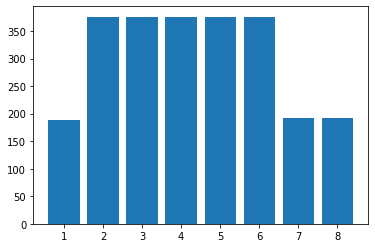

In [18]:
plt.bar(
    df_original.groupby(["emotion"]).loudness_sma3_amean.count().index,
    df_original.groupby(["emotion"]).loudness_sma3_amean.count(),
)

## Grupos para leave one group out

In [19]:
# logo = LeaveOneGroupOut()

In [20]:
# groups = (df_.actor // 2) + (df_propios.actor % 2)

In [21]:
# sorted(groups.unique())
# groups.value_counts()

In [22]:
# groups.sort_values().plot(kind="bar")

In [23]:
# X_train = df_proc.loc[groups <= 10, df_proc.columns != "emotion"]
# X_val = df_proc.loc[groups == 11, df_proc.columns != "emotion"]
# X_train_val = df_proc.loc[groups <= 11, df_proc.columns != "emotion"]
# X_test = df_proc.loc[groups == 12, df_proc.columns != "emotion"]

# y_train = df_proc.loc[groups <= 10, "emotion"]
# y_val = df_proc.loc[groups == 11, "emotion"]
# y_train_val = df_proc.loc[groups <= 11, "emotion"]
# y_test = df_proc.loc[groups == 12, "emotion"]

# group_train = [x for x in groups if x <= 10]
# group_val = [x for x in groups if x == 11]
# group_train_val = [x for x in groups if x <= 11]
# group_test = [x for x in groups if x == 12]

# Entrenando el mejor modelo (RF)

Al comparar las performance del bagging , el AdaBoost y el Random Forest se obtuvo un mejor desempeño por parte del RF con los siguientes hiperparámetros:

In [24]:
df_propios.shape

(42, 89)

In [25]:
df_propios.head()

,emotion,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,8,33.700836,0.151614,30.896828,35.477130,37.888770,6.991943,79.057495,34.982346,49.753742,...,0.006385,-0.002518,0.105235,3.582090,1.212121,0.595000,0.495404,0.166000,0.204020,-15.474176
1,5,39.358730,0.271838,36.973915,43.282550,46.085873,9.111958,97.191170,119.932250,105.989296,...,0.019754,0.010666,0.077570,3.084833,1.822917,0.347143,0.470371,0.178571,0.218137,-18.720428
2,3,42.000824,0.080393,39.967102,42.566326,44.228740,4.261639,61.089214,53.859688,20.160406,...,0.009773,0.010525,0.207873,3.603604,1.829268,0.363333,0.240463,0.194000,0.309102,-15.210293
3,5,43.330635,0.144818,40.813780,44.283394,47.908993,7.095211,153.982450,112.198630,51.583763,...,0.031997,0.010086,0.215785,3.278689,2.006689,0.296667,0.305050,0.204000,0.188743,-17.321493
4,3,37.003696,0.061324,35.190372,37.020550,38.557076,3.366703,63.024178,79.459946,27.501400,...,0.055411,-0.002039,0.098568,2.569593,1.731602,0.333750,0.267906,0.221250,0.298515,-19.152788


In [52]:
# X_train, x_test, y_train, y_test = train_test_split(
#     df_original.loc[:, df_original.columns != "emotion"],
#     df_original["emotion"],
#     stratify=df_original["emotion"],
#     random_state=PARAM_RANDOM_STATE,
# )

In [26]:
# rf = RandomForestClassifier(n_estimators=360, random_state=PARAM_RANDOM_STATE)
# rf.fit(X_train, y_train)
rf = pickle.load(open("03.04.Random_forest.pkl", "rb"))

C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Resultados

In [45]:
y_pred_propios = rf.predict(df_propios.loc[:, df_propios.columns != "emotion"])

In [46]:
# labels_cm = ['Neu.', 'Calm','Hap.','Sad','Angry','Fear.','Disg.','Surpr.']
labels_cm = ["Neu.", "Calm", "Hap.", "Sad", "Angry", "Fear.", "Disg.", "Surpr."]

In [47]:
unique, counts = np.unique(y_propios, return_counts=True)
dict(zip(unique, counts))

{1: 3, 2: 2, 3: 12, 4: 6, 5: 7, 7: 1, 8: 11}

In [48]:
unique, counts = np.unique(y_pred_propios, return_counts=True)
dict(zip(unique, counts))

{3: 3, 4: 1, 5: 19, 6: 18, 7: 1}

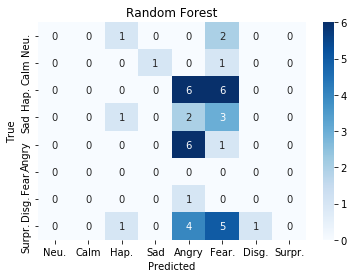

In [49]:
ax = plt.subplot()
cm = confusion_matrix(y_propios, y_pred_propios)
heat_rf_propios = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
ax.set_title("Random Forest")
ax.xaxis.set_ticklabels(labels_cm)
ax.yaxis.set_ticklabels(labels_cm)

heat_rf_propios.figure.savefig("05.01.Matriz_propios.random.png", bbox_inches="tight")

In [50]:
# evaluación
print("Test acc: {}".format(accuracy_score(y_propios, y_pred_propios)))
print("Test recall: {}".format(recall_score(y_propios, y_pred_propios, average="weighted")))
print(
    "Test F1: {}".format(fbeta_score(y_propios, y_pred_propios, beta=1, average="weighted"))
)
print(
    "Test F2: {}".format(fbeta_score(y_propios, y_pred_propios, beta=2, average="weighted"))
)

Test acc: 0.14285714285714285
Test recall: 0.14285714285714285
Test F1: 0.07692307692307693
Test F2: 0.10638297872340424


C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print(classification_report(y_propios, y_pred_propios))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         6
           5       0.32      0.86      0.46         7
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        11

    accuracy                           0.14        42
   macro avg       0.04      0.11      0.06        42
weighted avg       0.05      0.14      0.08        42



C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Probando con Adaboost

In [52]:
# best_adaboost = AdaBoostClassifier(
#     DecisionTreeClassifier(class_weight="balanced"),
#     n_estimators=1335,
#     learning_rate=1.6709999999999996,
#     random_state=PARAM_RANDOM_STATE,
# )
# best_adaboost.fit(X_train, y_train)
best_adaboost = pickle.load(open("03.05.AdaBoost.pkl", "rb"))

C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.24.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [53]:
y_pred_propios_ada = best_adaboost.predict(df_propios.loc[:, df_propios.columns != "emotion"])

In [54]:
# evaluación
print("Test acc: {}".format(accuracy_score(y_propios, y_pred_propios_ada)))
print("Test recall: {}".format(recall_score(y_propios, y_pred_propios_ada, average="weighted")))
print(
    "Test F1: {}".format(fbeta_score(y_propios, y_pred_propios_ada, beta=1, average="weighted"))
)
print(
    "Test F2: {}".format(fbeta_score(y_propios, y_pred_propios_ada, beta=2, average="weighted"))
)

Test acc: 0.3333333333333333
Test recall: 0.3333333333333333
Test F1: 0.258217296580468
Test F2: 0.2885072728278303


C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print(classification_report(y_propios, y_pred_propios_ada))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.36      0.67      0.47        12
           4       0.24      0.67      0.35         6
           5       1.00      0.29      0.44         7
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00        11

    accuracy                           0.33        42
   macro avg       0.20      0.20      0.16        42
weighted avg       0.30      0.33      0.26        42



C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


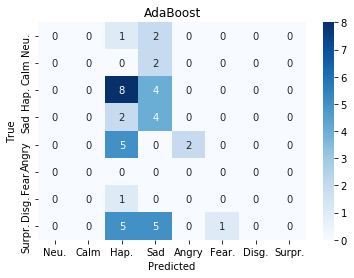

In [56]:
ax = plt.subplot()
cm = confusion_matrix(y_propios, y_pred_propios_ada)
heat_ad_propios = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
ax.set_title("AdaBoost")
ax.xaxis.set_ticklabels(labels_cm)
ax.yaxis.set_ticklabels(labels_cm)

heat_ad_propios.figure.savefig("05.02.Matriz_propios.ada.png", bbox_inches="tight")

In [57]:
best_adaboost

C:\Users\lbertolini\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=None,
                          